# Align audio between RME and videos

**Context:**
* Videos audio isn't synced between p1 and p2
* RME audio is sinced, but cannot be exactly aligned using DaVinci
* RME audio _can_ be faulty

**Goal:** for each video
1. Load 
    * audio from video, both channels
    * markers file
    * RME audio and locate clap
2. Compute lag between the two audios (using clap / triggers)
    - Crosscorrelation, DTW not working (computationally to greedy), but simple substraction works
    * Compare cam1 to RME then RME to cam2, to get cam1-cam2 alignment
3. For RME
    * locate clap / markers and lag to video
    * check that RME audio = video audio
4. Generate aligned audio files to use transcription on / align to EEG

**Anterior remarks**:
* Need to check how the audio is exported in the video - whether it's 1 channel or 2

In [ ]:
%%bash
pip install librosa
conda install -c conda-forge ffmpeg
pip install dtw
pip install dtaidistance
python -m pip install pwlf

In [2]:
import pandas as pd
import numpy as np
import sys, os
import subprocess
import audiofile
import librosa
import IPython
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from dtaidistance import dtw
import scipy.signal as sig #import hilbert
import scipy.stats as ss #pearsonr
import sklearn.preprocessing as skp # RobustScaler, StandardScaler

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


In [4]:
video_path = "../data/video"
audio_path = "../data/audio"
skip_sessions = []
markers_path = "../data/video/markers_from_video_start.csv"
markers = pd.read_csv(markers_path)

dest_folder = "../data/audio-aligned"
if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)

## Tests
### 1. Loading

In [5]:
# export audio from video
def convert_video_to_audio_ffmpeg(video_file, output_ext="wav", 
            audio_stream_to_map:int=1, target_fs:int=None, rs_use_sox:bool=False):
    """Converts video to audio directly using `ffmpeg` command
    with the help of subprocess module

    Options: 
    * map a given stream (1: camera audio; 2: RME audio)
    * downsample: `-af aresample=resampler=soxr -ar 16000`
    """
    filename, ext = os.path.splitext(video_file)
    ffmpeg_call = ["ffmpeg", "-y", "-i", video_file]
    # stream
    if audio_stream_to_map == 2:
        filename += "_rme"
        ffmpeg_call += ["-map", f"0:{audio_stream_to_map}"]
    # resample
    if target_fs is not None:
        ffmpeg_call += ["-ar", str(target_fs)]
        if rs_use_sox: 
            ffmpeg_call += ["-af", "aresample=resampler=soxr"]
    # call
    ffmpeg_call.append(f"{filename}.{output_ext}")
    #print(' '.join(ffmpeg_call))
    subprocess.call(ffmpeg_call, 
                    stdout=subprocess.DEVNULL,
                    stderr=subprocess.STDOUT)
    # return name
    return f"{filename}.{output_ext}"

Export audio for all videos: (1. camera - 2. RME)

In [201]:
vfolder = "221207_LBMC"
[date, group] = vfolder.split("_")
video_export = f"bkt-{date}-{group}.mov"
vaudio_name = f"bkt-{date}-{group}.wav"
raudio_name = f"bkt-{date}-{group}_rme.wav"

# load audio from video
vaudio, vfs = audiofile.read(os.path.join(video_path, vfolder, vaudio_name))

# load audio from RME
raudio, rfs = audiofile.read(os.path.join(video_path, vfolder, raudio_name))

# check the number of channels in the audio + duration
print(vaudio.shape, raudio.shape)

# get markers in audio
mark = markers.loc[markers.file == vfolder].iloc[0]
mark

(2, 29984640) (2, 29984640)


file                 221207_LBMC
Start                        0.0
Watch p1                    1.12
Watch p2                    5.24
Clap                       28.36
Start Task 1               36.16
End Task 1                997.44
End Task 2               1873.92
Stop                      1874.0
Actual End Task 1            NaN
Name: 23, dtype: object

In [31]:
# Listening to audio
IPython.display.Audio(data = vaudio[1,:], rate=vfs)

In [203]:
# Reloading with downsampling
vaudio, vfs = librosa.load(os.path.join(video_path, vfolder, vaudio_name), sr=8000, mono=False) # Downsample 48kHz to 8kHz
raudio, rfs = librosa.load(os.path.join(video_path, vfolder, raudio_name), sr=8000, mono=False)

#vaudio_sc = skp.RobustScaler().fit(vaudio.reshape())
#raudio_sc = skp.RobustScaler().fit(raudio.reshape())

In [45]:
#audio_clap = int(mark.Clap*vfs)
audio_clap = int(mark['End Task 1']*vfs)
swindow = int(1*vfs)
wstart = audio_clap - swindow
wstop = audio_clap + swindow

### 2. Computing delay - Signal analysis
Computing envelope, DTW and crosscorrelation metrics - too computationally greedy

In [6]:
def get_envelope(signal:np.array):
    analytic_signal = sig.hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

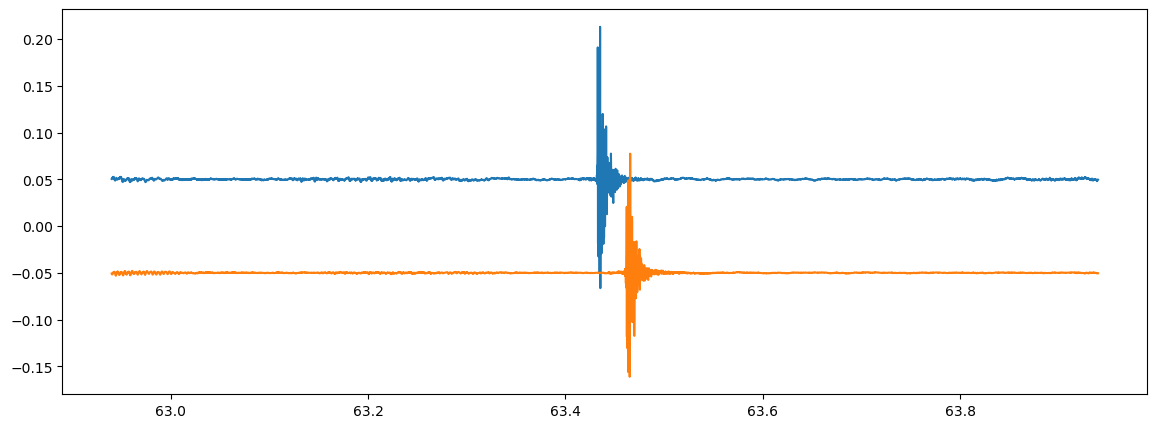

In [174]:
fig, ax = plt.subplots(figsize=(14,5))
for channel in [0,1]:
    sign = -1 if channel == 1 else 1
    ts = np.array(range(wstart,wstop))/vfs
    signal = vaudio[channel,wstart:wstop]
    plt.plot(ts, signal+sign*0.05)
    #amplitude_envelope = get_envelope(signal)
    #plt.plot(ts, amplitude_envelope+sign*0.5)
#plt.plot(np.array(range(wstart,wstop))/vfs, vaudio[1,wstart:wstop]-0.5)

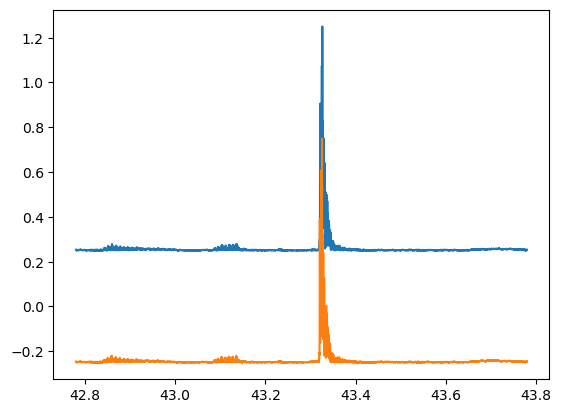

In [24]:
d1 = skp.MinMaxScaler().fit_transform(get_envelope(vaudio[1,wstart:wstop])[:, np.newaxis])
d2 = skp.MinMaxScaler().fit_transform(get_envelope(raudio[1,wstart:wstop])[:, np.newaxis])
plt.plot(np.array(range(wstart,wstop))/vfs, d1+0.25)
plt.plot(np.array(range(wstart,wstop))/vfs, d2-0.25)

In [80]:
from dtw import dtw,accelerated_dtw

d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

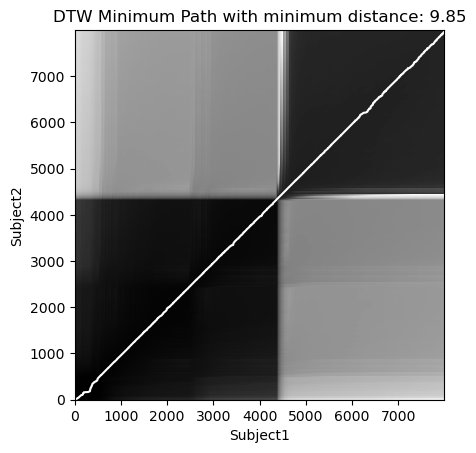

In [81]:
plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('Subject1')
plt.ylabel('Subject2')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.show()

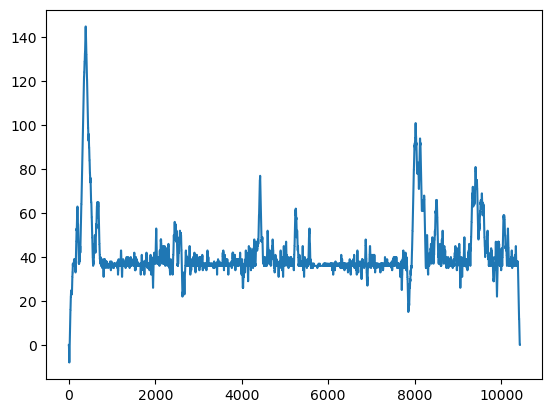

In [87]:
plt.plot(path[0] - path[1])

In [98]:
d1.shape

(8000, 1)

In [100]:
l = []
for step in range(1,100):
    l.append(np.corrcoef(d1[0+step:8000-100+step], d2[0:7000]))

/Users/eliot/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/eliot/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/eliot/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


: 

: 

In [89]:
import whisper
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def get_mel(audio, device=DEVICE):
    audio = whisper.pad_or_trim(audio.flatten()).to(device) 
    # docstring: whisper.pad_or_trim(array, length: int = 480000, *, axis: int = -1)
    mel = whisper.log_mel_spectrogram(audio)
    return mel

<AxesSubplot:>

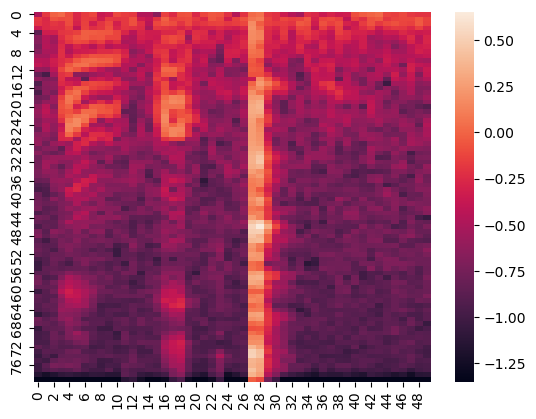

In [95]:
audio = torch.Tensor(vaudio[0,wstart:wstop], device=DEVICE)
sns.heatmap(whisper.log_mel_spectrogram(audio))

<AxesSubplot:>

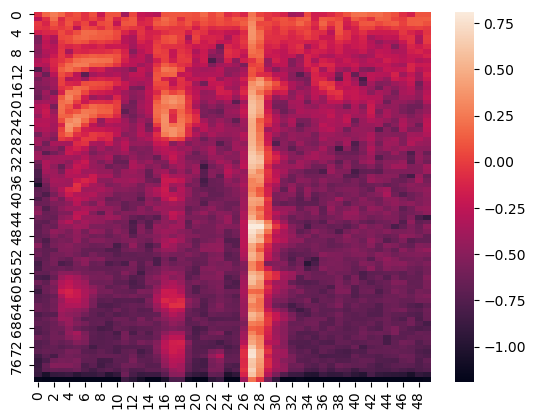

In [96]:
audio = torch.Tensor(raudio[0,wstart:wstop], device=DEVICE)
sns.heatmap(whisper.log_mel_spectrogram(audio))

In [14]:
from dtaidistance import dtw

d = dtw.distance_fast(d1.astype('double'), d2.astype('double'), use_pruning=True)
# 2 hours later, still not done

In [12]:
vaudio, vfs = librosa.load('../data/test-tracks-bus-2.wav', sr=8000, mono=False) # Downsample 44.1kHz to 8kHz
#raudio, rfs = librosa.load(os.path.join(audio_path, rme_name), sr=8000) # Downsample 44.1kHz to 8kHz

d1 = vaudio[0]#raudio[0]
d2 = vaudio[1]
d = dtw.distance_fast(d1.astype('double'), d2.astype('double'), use_pruning=True)


### 2. Computing delay - Simpler methods

In [7]:
def get_delay_at_clap(vaudio:np.array, raudio:np.array, fs:int, fps:int=25, 
                    plot_delay:bool=False, return_df:bool=False, n_frames:int=2, **kwargs):
    """Look for delay (in sample points) between two signals for the same participant - window should already have been selected
    """
    if (vaudio.shape != raudio.shape):
        raise IndexError("Both signal should have the same shape.")
    elif vaudio.shape[0] > fs*10:
        raise IndexError("For higher accuracy, signal should be cut as a short window around Clap marker time.")

    # Step 1: extract envelope and normalise - window should already have been selected
    d1 = skp.MinMaxScaler().fit_transform(get_envelope(vaudio)[:, np.newaxis])
    d2 = skp.MinMaxScaler().fit_transform(get_envelope(raudio)[:, np.newaxis])
    # Step 2: look for delay
    l = []
    max_lag = int(n_frames*(fs/fps)) # delay is shorter than 1 frame, taking 2 on each side for safety - might need to change to 10
    tstart = 0 + max_lag
    tstop = d1.shape[0] - max_lag
    for step in range(-max_lag,max_lag):
        s = (d1[tstart+step:tstop+step] - d2[tstart:tstop])
        l.append([s.mean(), s.min(), s.max(), s.std()])
    l = pd.DataFrame(l, columns=['mean','min','max','std'], index=range(-max_lag,max_lag))
    
    # Step 3: return
    if plot_delay:
        l.plot()
    if return_df:
        return l
    return l['std'].idxmin()

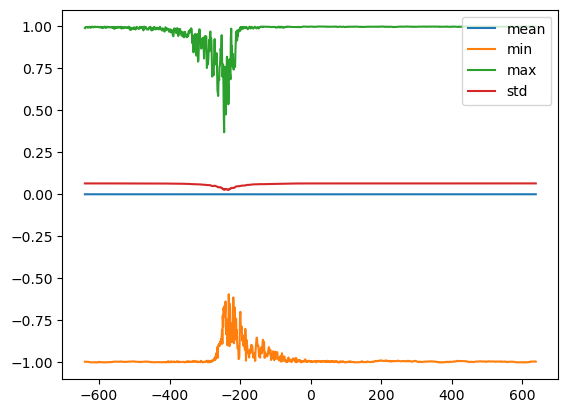

In [175]:
l = get_delay_at_clap(vaudio[0,wstart:wstop], vaudio[1,wstart:wstop], fs=8000, plot_delay=True, return_df=True)

In [8]:
def align_two_cameras(vaudio:np.array, raudio:np.array, **kwargs):
    """Look for delay (in sample points) between two participants in video audio - window should already have been selected
    """
    if (vaudio.shape != raudio.shape):
        raise IndexError("Both signal should have the same shape.")
    elif vaudio.shape[0] != 2:
        raise IndexError("Audio should have two channels.")

    # Participant 1
    del1 = get_delay_at_clap(vaudio[0,:], raudio[0,:], **kwargs)
    # Participant 2
    del2 = get_delay_at_clap(vaudio[1,:], raudio[1,:], **kwargs)
    # Return delay p1-p2 = p1 to audio, then audio to p2
    return del1 - del2   

In [9]:
def pad_or_trim_audio(signal:np.array, step_shift:int, all_channels:bool=False):
    """Shift signal by step_shift, pad and trim at start/end depending on need
    Note: if all_channels=False, then only the second channel is moved
    """
    ssh = signal.shape
    step_shift = -step_shift
    if all_channels:
        new_array = []
    else:
        new_array = [signal[0,:]]
        signal = signal[1:,:]
    # set parameters
    if step_shift > 0:
        bounds = (0,step_shift)  
        sst = [step_shift,signal.shape[1]+step_shift]
    else: 
        bounds = (-step_shift,0)
        sst = [0,signal.shape[1]]
    # pad or trim each row
    for channel in range(signal.shape[0]):
        sig = signal[channel,:]
        sig = np.pad(sig, bounds, 'constant', constant_values=(0, 0))
        sig = sig[sst[0]:sst[1]]
        new_array.append(sig)

    return np.concatenate(new_array).reshape(ssh)

In [240]:
def align_audios(vaudio:np.array, raudio:np.array, clap_marker:float, fs:int, **kwargs):
    """Returns the aligned audios
    kwargs include fs
    """
    kwargs['fs'] = fs
    # Define marker
    audio_clap = int(mark.Clap*fs)
    swindow = int(0.5*fs)
    wstart = audio_clap - swindow
    wstop = audio_clap + swindow
    # Align two cameras
    step = align_two_cameras(vaudio[:,wstart:wstop], raudio[:,wstart:wstop], **kwargs) # step is the number of elements for the shift
    vaudio_align = pad_or_trim_audio(signal=vaudio, step_shift=step)
    # Align cameras and RME
    del1 = get_delay_at_clap(vaudio[0,wstart:wstop], raudio[0,wstart:wstop], **kwargs)
    raudio_align = pad_or_trim_audio(signal=raudio, step_shift=del1, all_channels=True)
    # Return aligned signals, window of computation, time difference between the camera audios
    return vaudio_align, raudio_align, (wstart,wstop), step/fs

def visual_check(vaudio_align, raudio_align, boundaries:tuple, fs:int, ax=None):
    (wsr,wst) = boundaries
    ts = np.array(range(wsr,wst))/fs
    if ax is None:
        _, ax = plt.subplots(figsize=(14,5))
    ax.plot(ts, vaudio_align[0,wsr:wst], label="cam_1")
    ax.plot(ts, vaudio_align[1,wsr:wst], alpha=0.5, label="cam_2")
    ax.plot(ts, raudio_align[0,wsr:wst]-0.05, alpha=0.5, label="rme_1")
    ax.plot(ts, raudio_align[1,wsr:wst]-0.05, alpha=0.5, label='rme_2')
    ax.legend()

0.048


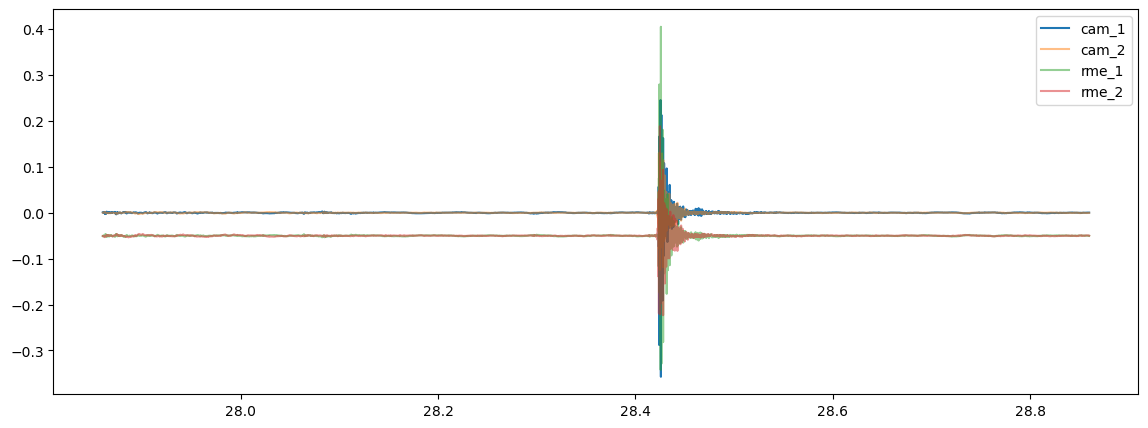

In [241]:
vaudio_align, raudio_align, (wsr,wst), vdiff = align_audios(vaudio, raudio, mark.Clap, fs=8000)
print(vdiff)
visual_check(vaudio_align, raudio_align, (wsr,wst), fs=8000)

time: 7min 18s


Text(0.5, 1.0, '221207_LBMC')

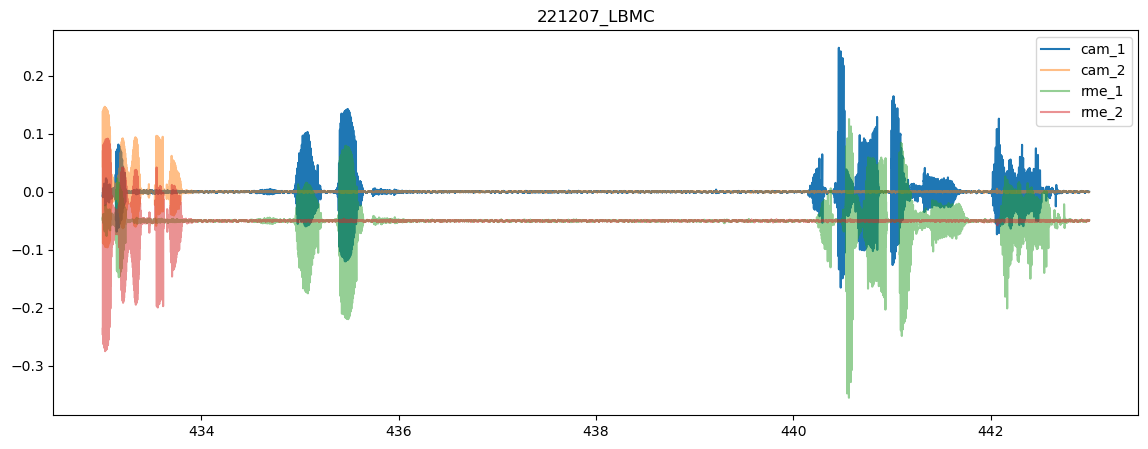

In [235]:
time = 438
print(f"time: {time//60}min {time%60}s")
visual_check(vaudio_align, raudio_align, (int(time-5)*vfs,int(time+5)*vfs), fs=vfs)
plt.title(vfolder)
#visual_check(vaudio_align, raudio_align, (346240,348240))

In [ ]:
get_delay_at_clap(vaudio[0,wstart:wstop], raudio[0,wstart:wstop], fs=8000)

**Checking whether signal disaligns**:
<br>We need to check whether there is a point at which the difference between the two signals becomes stronger

In [22]:
def monitor_alignment(vaudio_align:np.array, raudio_align:np.array, fs:int, audio_clap:float=None, plot_figure:bool=False, **kwargs):
    """Check every 10s (-ish) the alignment
    """
    df = {'ts':[], 'val':[]}
    rs = fs if audio_clap is None else int((np.round(audio_clap%1, decimals=3)+1)*fs)
    r = range(rs, vaudio_align.shape[1]-fs, 10*fs) # jump every 10 seconds, until 1s before end - df won't be aligned
    for m_clap in r:
        swindow = int(0.5*fs)
        wstart = m_clap - swindow
        wstop = m_clap + swindow
        delay = get_delay_at_clap(vaudio_align[0,wstart:wstop], raudio_align[0,wstart:wstop], fs=fs, **kwargs)
        df['ts'].append(m_clap/fs)
        df['val'].append(delay/fs) # in s
    
    df = pd.DataFrame(df)
    if audio_clap is not None:
        df['ts'] = df['ts'] - audio_clap
    df = df.set_index('ts')
    if plot_figure:
        fig, ax = plt.subplots(figsize=(14,5))
        # plot evolution of disalignment
        df.plot(ax=ax)
        ax.set_xlabel("Time (in s) since recording start")
        ax.set_ylabel("Drift (in s) after aligning at clap")
        # use marker
        ax.vlines(0., df.val.min(), df.val.max(), linestyles='dashed')
    else:
        return df

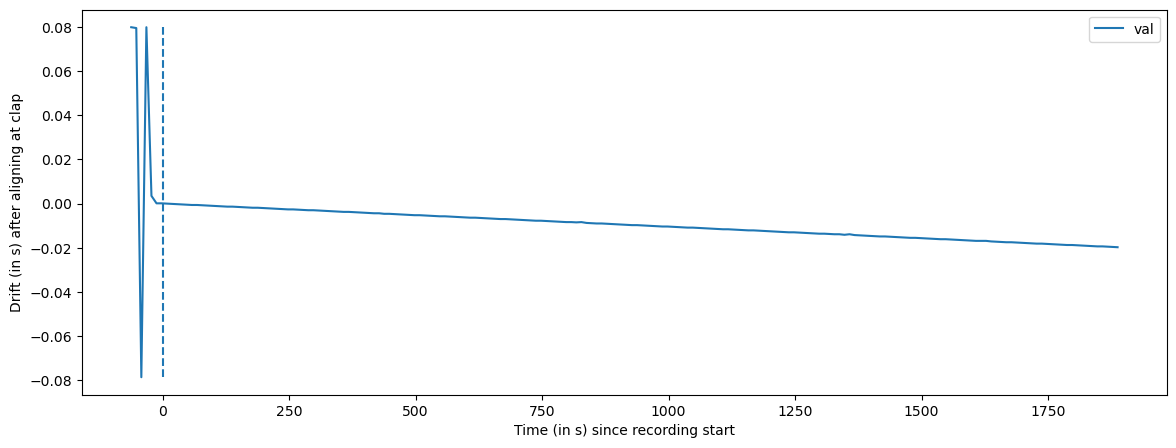

In [186]:
monitor_alignment(vaudio_align, raudio_align, 8000, mark['Clap'], plot_figure=True)

Note: ignore what happens before `Clap`. RME sound might not have started yet.

## Pipeline

In [12]:
vfolders = [vfolder for vfolder in sorted(os.listdir(video_path)) if os.path.isdir(os.path.join(video_path, vfolder))]

In [13]:
# For each file
drift = []
overwrite_audio = True
for i, vfolder in enumerate(vfolders):
    print(f"Analysing {i+1}/{len(vfolders)} {vfolder}", end="\t")
    try:
        # 0. Read video and create wav files
        [date, group] = vfolder.split('_')
        video = os.path.join(video_path, vfolder, f"bkt-{date}-{group}.mov")
        if overwrite_audio or not os.path.exists(video.replace('.mov','.wav')):
            vaudio_name = convert_video_to_audio_ffmpeg(video, target_fs=16000)
            raudio_name = convert_video_to_audio_ffmpeg(video, audio_stream_to_map=2, target_fs=16000)
            print("Extraction done.", end=" ")
        # get markers in audio
        mark = markers.loc[markers.file == vfolder].iloc[0]
        
        # 1. Read audio files
        # If downsampling needed: sr=[new_fs]
        vaudio, vfs = librosa.load(vaudio_name, mono=False) 
        raudio, rfs = librosa.load(raudio_name, mono=False)
        assert vfs == rfs

        # 2. Compute delay and align
        vaudio_align, raudio_align, (wsr,wst), vdiff = align_audios(vaudio, raudio, mark.Clap, fs=vfs)
        # 3. Compute drift and delay
        df = monitor_alignment(vaudio_align, raudio_align, vfs, mark['Clap']).reset_index(drop=False)
        df['src'] = vfolder
        drift.append(df)
        
        # 4. Write realigned audio to file
        print("Writing audio...", end=" ")
        output_file = os.path.join(dest_folder, f"bkt-{date}-{group}.wav")
        audiofile.write(output_file, vaudio_align, vfs, bit_depth=32)
        audiofile.write(output_file.replace('.wav','_rme.wav'), raudio_align, vfs, bit_depth=32)
        print('Done. Audio delay between cameras: ', vdiff)
    except Exception as e:
        print(e)

Analysing 1/28 221116_CGLS	Extraction done. Writing audio... Done. Audio delay between cameras:  -0.022630385487528343
Analysing 2/28 221117_TFGG	Extraction done. Writing audio... Done. Audio delay between cameras:  0.003945578231292517
Analysing 3/28 221118_GDNF	Extraction done. Writing audio... Done. Audio delay between cameras:  -0.030113378684807256
Analysing 4/28 221118_VPET	Extraction done. Writing audio... Done. Audio delay between cameras:  0.004852607709750567
Analysing 5/28 221121_JPMC	Extraction done. Writing audio... Done. Audio delay between cameras:  0.0038095238095238095
Analysing 6/28 221122_BDCC	Extraction done. Writing audio... Done. Audio delay between cameras:  -0.00018140589569160998
Analysing 7/28 221122_EBPT	Extraction done. Writing audio... Done. Audio delay between cameras:  0.004399092970521542
Analysing 8/28 221123_JFHB	Extraction done. Writing audio... Done. Audio delay between cameras:  0.003945578231292517
Analysing 9/28 221123_MMCM	Extraction done. Writin

In [14]:
cam_delay = { 
    "221116_CGLS":-0.022630385487528343,
    "221117_TFGG":0.003945578231292517, "221118_GDNF":-0.030113378684807256,
    "221118_VPET":0.004852607709750567, "221121_JPMC":0.0038095238095238095,
    "221122_BDCC":-0.00018140589569160998, "221122_EBPT":0.004399092970521542,
    "221123_JFHB":0.003945578231292517, "221123_MMCM":-0.029206349206349208,
    "221123_YAEB":-0.02489795918367347, "221125_FDCC":-0.0044444444444444444,
    "221128_EMTR":-0.03160997732426304, "221128_LBRA":-0.0254421768707483,
    "221130_AMLB":-0.027664399092970523, "221130_ASCS":0.0,
    "221130_PCEF":-0.012018140589569161, "221130_TFLH":-0.015918367346938776,
    "221201_LIVS":-0.008526077097505668, "221201_MMLM":-0.011428571428571429,
    "221202_ELLD":-0.028888888888888888, "221205_KMJF":-0.0327437641723356,
    "221206_LKCR":-0.03183673469387755, "221206_MMER":0.00036281179138321996,
    "221207_LBMC":0.04793650793650794, "221207_SALT":-0.000997732426303855,
    "221207_SLCB":-0.031020408163265307, "221208_MBLB":-0.0017233560090702948,
    "221215_AGET":-0.026439909297052155
}

Text(0, 0.5, 'density of files')

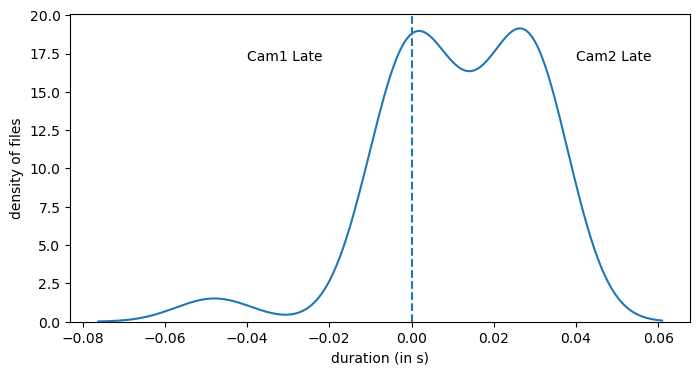

In [268]:
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(-np.array(list(cam_delay.values())), ax=ax)
ax.axvline(ymax=20, linestyle='--')
ax.text(x=-0.04, y=17, s='Cam1 Late')
ax.text(x=0.04, y=17, s='Cam2 Late')
ax.set_xlabel('duration (in s)')
ax.set_ylabel('density of files')

### Analysing
Are there sudden jumps in the values for some folders? How frequently?

In [16]:
# Might need to reload and reexecute drift computation with wider window
redo = True
if 'drift' not in locals() or redo:
    drift = []
    for i, vfolder in enumerate(vfolders):
        print(f"Analysing {i+1}/{len(vfolders)} {vfolder}", end="\t")
        [date, group] = vfolder.split('_')
        mark = markers.loc[markers.file == vfolder].iloc[0]
        try:
            vaudio_align, vfs = audiofile.read(os.path.join(dest_folder, f'bkt-{date}-{group}.wav'))
            raudio_align, rfs = audiofile.read(os.path.join(dest_folder, f'bkt-{date}-{group}_rme.wav'))
            df = monitor_alignment(vaudio_align, raudio_align, vfs, mark['Clap'], n_frames=10).reset_index(drop=False)
            df['src'] = vfolder
            drift.append(df)
            print()
        except:
            print("No files.")

Analysing 1/28 221116_CGLS	
Analysing 2/28 221117_TFGG	
Analysing 3/28 221118_GDNF	
Analysing 4/28 221118_VPET	
Analysing 5/28 221121_JPMC	
Analysing 6/28 221122_BDCC	
Analysing 7/28 221122_EBPT	
Analysing 8/28 221123_JFHB	
Analysing 9/28 221123_MMCM	
Analysing 10/28 221123_YAEB	
Analysing 11/28 221125_FDCC	
Analysing 12/28 221128_EMTR	
Analysing 13/28 221128_LBRA	
Analysing 14/28 221130_AMLB	
Analysing 15/28 221130_ASCS	
Analysing 16/28 221130_PCEF	
Analysing 17/28 221130_TFLH	
Analysing 18/28 221201_LIVS	
Analysing 19/28 221201_MMLM	
Analysing 20/28 221202_ELLD	
Analysing 21/28 221205_KMJF	
Analysing 22/28 221206_LKCR	
Analysing 23/28 221206_MMER	
Analysing 24/28 221207_LBMC	
Analysing 25/28 221207_SALT	
Analysing 26/28 221207_SLCB	No files.
Analysing 27/28 221208_MBLB	
Analysing 28/28 221215_AGET	


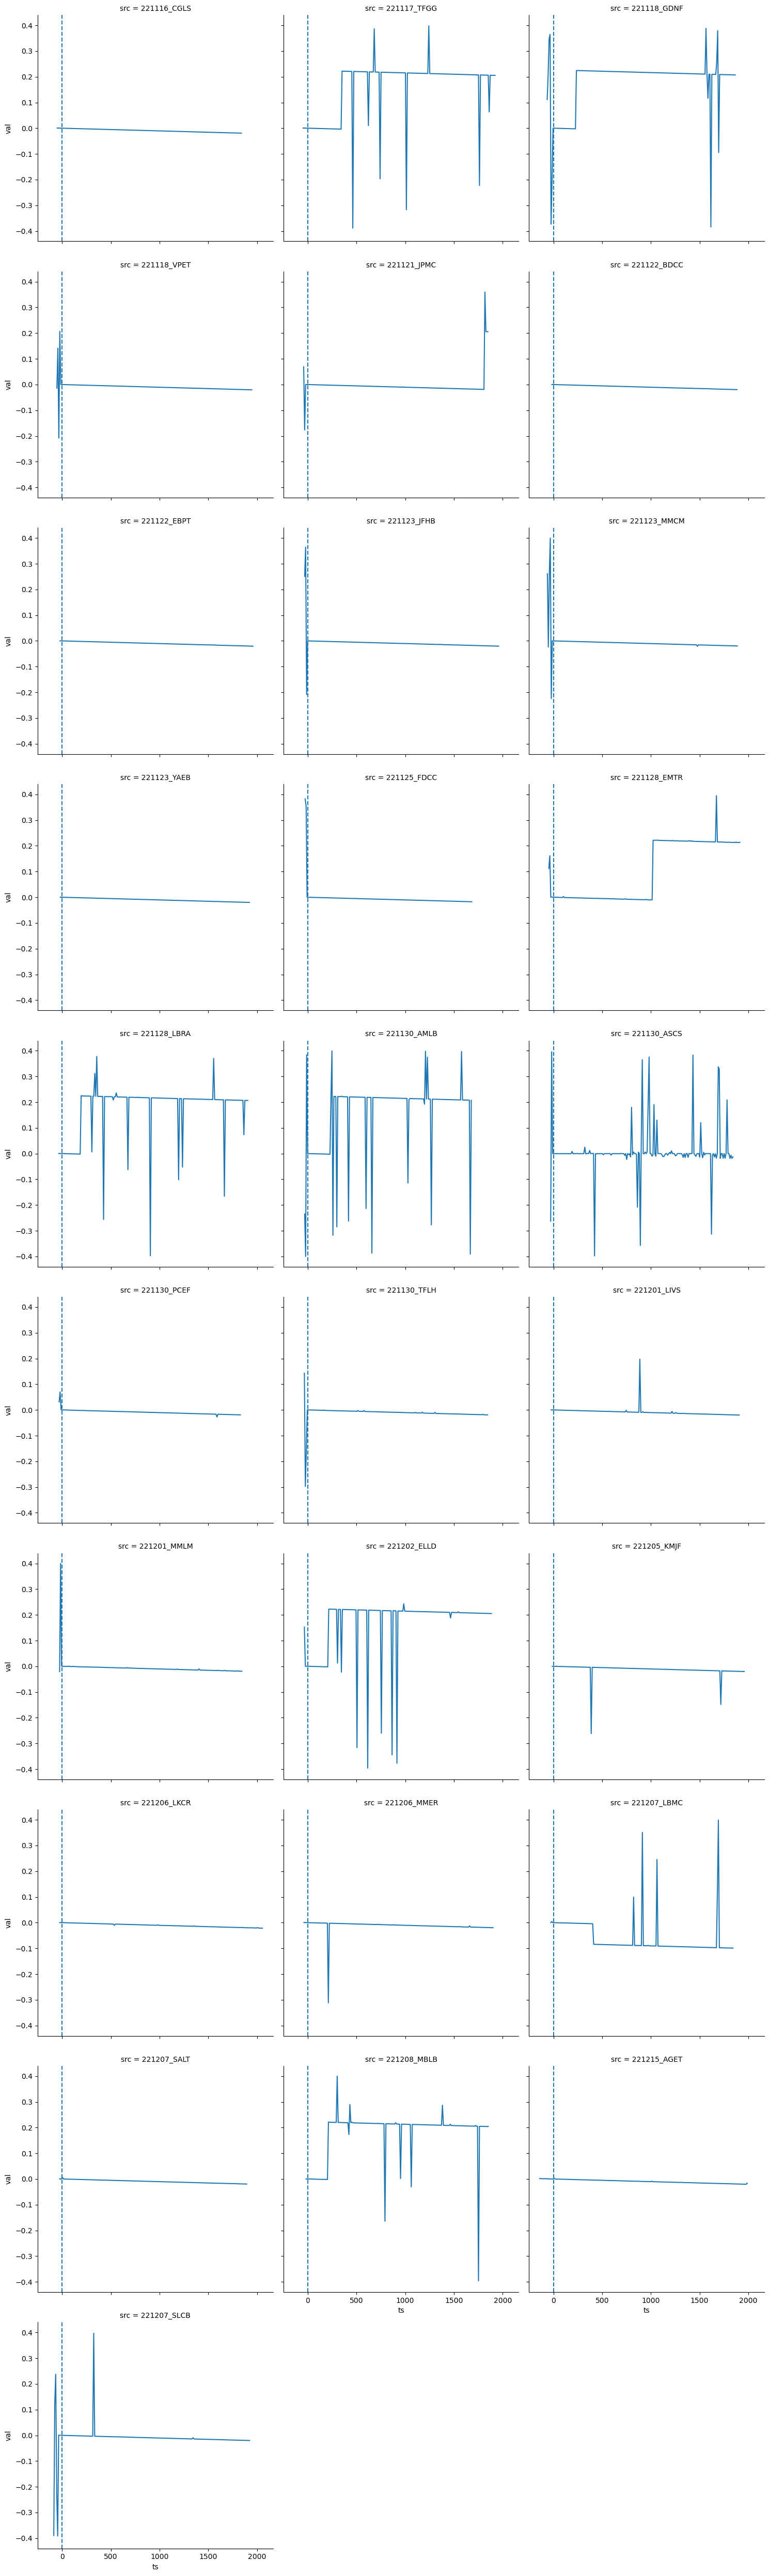

In [26]:
drift = pd.concat(drift, axis=0)
g = sns.relplot(data=drift, x='ts',y='val', col='src', kind="line", col_wrap=3)

for ax in g.axes:
    ax.axvline(x=0, linestyle='dashed')
#g.map(_add_vline_zero, 'ts','val') # not working

Objectives: 
* Check slope (drift) is the same for all
* Locate and list all skips ( > 0: RME deletes audio ; < 0: camera deletes audio)

In [ ]:
# Method 1 - transform ts into datetime index
# pd.to_datetime(drift[(drift.src == '221208_MBLB') & (drift.ts > 0)].ts.tolist(), unit="s")
# Method 2 - transform ts into period index
#pd.PeriodIndex(drift[(drift.src == '221208_MBLB') & (drift.ts > 0)].ts.apply(
#    lambda x: f"00:{str(int(x//60)).zfill(2)}:{str(int(x%60)).zfill(2)}"), freq="S")
# NOT WORKING FOR SECONDS
# from statsmodels.tsa.seasonal import seasonal_decompose
# result = seasonal_decompose(series, model='additive')

In [186]:
seasonal_df = drift[(drift.src == '221130_AMLB') & (drift.ts > 0)].set_index('ts')
#seasonal_df[(seasonal_df.val.diff()).diff() > 0.05]
seasonal_df['is_outlier'] = seasonal_df.val.diff().diff().abs() > 0.02
# correct so that one can't affect the next two
ds = pd.concat([seasonal_df['is_outlier'].shift(2), seasonal_df['is_outlier'].shift(1), seasonal_df['is_outlier']], axis=1)
ds.columns = [1,2,3]
ds = ds.fillna(False).astype(int).apply(lambda x: int(f"{x[1]}{x[2]}{x[3]}",2), axis=1)
io_1 = (ds == 1)
# in some cases it also squeezes the next outlier so correct that
io_2 = (seasonal_df['val'].shift() - seasonal_df['val']).abs() > 0.1 
seasonal_df['is_outlier'] = io_2 #pd.concat([io_1, io_2], axis=1).any(axis=1)

<AxesSubplot:xlabel='ts', ylabel='val'>

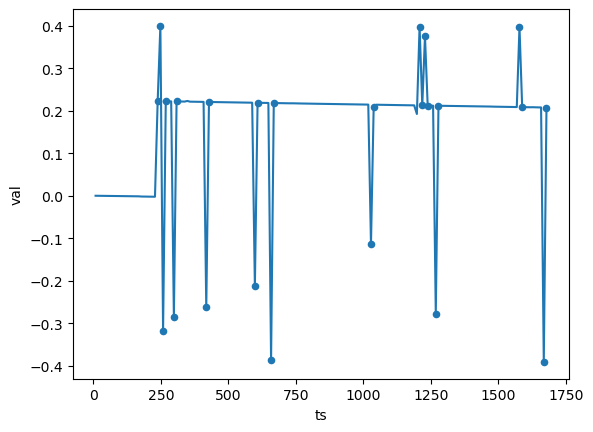

In [187]:
fig, ax = plt.subplots()
seasonal_df.val.plot(ax=ax)
seasonal_df[seasonal_df.is_outlier].reset_index(drop=False).plot.scatter('ts','val', ax=ax)

In [133]:
# compute slope and origin after each break (origin from 0)
# 

ts
2.0            NaN
12.0      0.000454
22.0     -0.000680
32.0      0.000045
42.0      0.000771
            ...   
1812.0   -0.000091
1822.0   -0.000091
1832.0   -0.000091
1842.0   -0.000091
1852.0    0.000227
Name: val, Length: 178, dtype: float64

<AxesSubplot:xlabel='ts'>

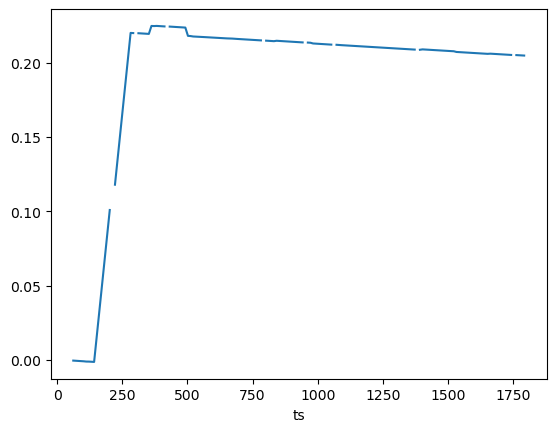

In [143]:
seasonal_df["trend"] = seasonal_df[~seasonal_df.is_outlier]["val"].rolling(window=13, center=True).mean()
seasonal_df["trend"].plot()

Once outliers have been removed, fit models to get number of lines + linear models taking breaks into account
* Count number of lines: fit clustering algorithms
* [Piece-wise linear models](https://jekel.me/piecewise_linear_fit_py/index.html)

In [35]:
import pwlf
from copy import deepcopy
from tqdm import tqdm

In [126]:
def get_optimal_pwf(fdrift:pd.DataFrame, max_slopes:int=10, 
                slope_add_min:float=0.01, cumsum_min:float=None,
                print_tqdm:bool=True):
    """Loop method to find the optimal number of break point / slopes - works on small datasets
    """
    x = fdrift['ts']
    y = fdrift['val']
    fslopes = pwlf.PiecewiseLinFit(x, y)
    data = {}
    r_squared = []
    ar = tqdm(range(1,max_slopes)) if print_tqdm else range(1,max_slopes)
    for i in ar:
        res = fslopes.fit(i)
        r = fslopes.r_squared()
        data[i] = {
            'model': deepcopy(fslopes), # copy fitted model
            'breaks': res,
            'r_squared': r
        }
        r_squared.append(r)

    r_squared = np.array(r_squared)
    if cumsum_min is not None:
        r_squared = np.where(r_squared > cumsum_min)[0]
        if len(r_squared) > 0: 
            return r_squared[0]+1, data # +1 because starts at 1 not 0
    best_val = (np.diff(r_squared) > slope_add_min).sum() + 1 # +1 because starts at 1 not 0
    return best_val, data

In [87]:
#fdrift = drift[(drift.src == '221208_MBLB') & (drift.ts > 0)]
fdrift = seasonal_df[~seasonal_df.is_outlier].reset_index()
n_slopes, models = get_optimal_pwf(fdrift)
#n_slopes = 3
fslopes = models[n_slopes]
breaks = fslopes['breaks']
fslopes = fslopes['model']
n_slopes, breaks

100%|██████████| 9/9 [00:14<00:00,  1.56s/it]

[0.2485872  0.8701758  0.99414863 0.99420455 0.99520534 0.99992504
 0.99992817 0.99993282 0.99993303]


(3, array([   2.        ,  209.39589328,  222.08255591, 1852.        ]))

In [90]:
x = fdrift.ts
y = fdrift.val
slopes = fslopes.calc_slopes()
A = fslopes.assemble_regression_matrix(breaks, x)
slopes, fslopes.lstsq(A), fslopes.p_values()

(array([-1.09450725e-05,  1.76967693e-02, -1.15508402e-05]),
 0.005014167651774421,
 array([9.33292293e-001, 5.72278464e-001, 5.47642811e-141, 1.25611429e-146]))

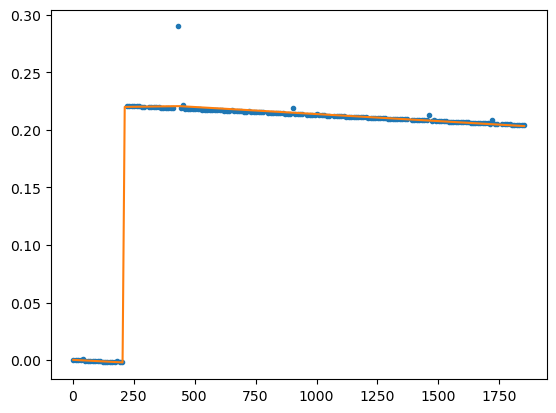

In [75]:
# -- for the plot predict for the determined points
xHat = np.linspace(min(x), max(x), num=10000)
yHat = fslopes.predict(xHat)

# plot the results
plt.figure()
plt.plot(x, y, '.')
plt.plot(xHat, yHat, '-')
plt.show()

Once the slopes computed, need to 
1. select areas with actual samples and keep slopes (those are < 1)
2. compute skips for all breaks

In [243]:
def compute_skips(fdrift, breaks, slopes, clap_time:float, min_slope_int:float=0.001):
    # for each slope of interest
    skips = []
    drft = []
    for i, slope in enumerate(slopes):
        if abs(slope) > min_slope_int:
            break_start = breaks[i]
            break_end = breaks[i+1]
            x = (break_start + break_end) / 2
            # match to closest ts value in drift array:
            break_start = fdrift[fdrift.ts < break_start].iloc[-1] # take before value - ts and val
            break_end = fdrift[fdrift.ts > break_end].iloc[0] # take after value - ts and val
            skip = break_end.val - break_start.val
            skips.append((x+clap_time, skip)) # drift has been reindexed from clap
        else:
            drft.append(slope)
    return skips, drft


In [123]:
skips, drft = compute_skips(fdrift, breaks, slopes, mark.Clap)
skips

[(215.7392245958838, 0.22281179138321994)]

For all files:

In [245]:
best_models = {}
all_skips = {}
all_drifts = []
for i, vfolder in enumerate(vfolders):
    print(f"Analysing {i+1}/{len(vfolders)} {vfolder}")
    #### compute df and remove outliers
    seasonal_df = drift[(drift.src == vfolder) & (drift.ts > 0)].set_index('ts')
    seasonal_df['is_outlier'] = seasonal_df.val.diff().diff().abs() > 0.02
    # correct so that one can't affect the next two
    ds = pd.concat([seasonal_df['is_outlier'].shift(2), seasonal_df['is_outlier'].shift(1), seasonal_df['is_outlier']], axis=1)
    ds.columns = [1,2,3]
    ds = ds.fillna(False).astype(int).apply(lambda x: int(f"{x[1]}{x[2]}{x[3]}",2), axis=1)
    io_1 = (ds == 1)
    # in some cases it also squeezes the next outlier so correct that
    io_2 = (seasonal_df['val'].shift() - seasonal_df['val']).abs() > 0.1 
    seasonal_df['is_outlier'] = io_2 #pd.concat([io_1, io_2], axis=1).any(axis=1)
    #### compute slopes
    fdrift = seasonal_df[~seasonal_df.is_outlier].reset_index()
    n_slopes, models = get_optimal_pwf(fdrift, print_tqdm=False)
    fslopes = models[n_slopes]
    breaks = fslopes['breaks']
    fslopes = fslopes['model']
    #### store
    slopes = fslopes.calc_slopes()
    skips, drft = compute_skips(fdrift, breaks, slopes, markers.loc[markers.file == vfolder].iloc[0].Clap)
    best_models[vfolder] = fslopes
    all_skips[vfolder] = skips
    all_drifts += drft

Analysing 1/28 221116_CGLS
Analysing 2/28 221117_TFGG
Analysing 3/28 221118_GDNF
Analysing 4/28 221118_VPET
Analysing 5/28 221121_JPMC
Analysing 6/28 221122_BDCC
Analysing 7/28 221122_EBPT
Analysing 8/28 221123_JFHB
Analysing 9/28 221123_MMCM
Analysing 10/28 221123_YAEB
Analysing 11/28 221125_FDCC
Analysing 12/28 221128_EMTR
Analysing 13/28 221128_LBRA
Analysing 14/28 221130_AMLB
Analysing 15/28 221130_ASCS
Analysing 16/28 221130_PCEF
Analysing 17/28 221130_TFLH
Analysing 18/28 221201_LIVS
Analysing 19/28 221201_MMLM
Analysing 20/28 221202_ELLD
Analysing 21/28 221205_KMJF
Analysing 22/28 221206_LKCR
Analysing 23/28 221206_MMER
Analysing 24/28 221207_LBMC
Analysing 25/28 221207_SALT
Analysing 26/28 221207_SLCB
Analysing 27/28 221208_MBLB
Analysing 28/28 221215_AGET


In [246]:
np.median(all_drifts)*(3600/2) # drift for half an hour experiment

-0.01880009267986841

In [247]:
ok_files = [k for k,v in all_skips.items() if len(v) == 0]
ko_files = pd.DataFrame({k:vals for k,v in all_skips.items() if len(v) > 0 for vals in v}).T
ko_files.columns = ['index', 'duration']
print(ok_files)
ko_files

['221116_CGLS', '221118_VPET', '221122_BDCC', '221122_EBPT', '221123_JFHB', '221123_MMCM', '221123_YAEB', '221125_FDCC', '221130_PCEF', '221130_TFLH', '221201_LIVS', '221201_MMLM', '221205_KMJF', '221206_LKCR', '221206_MMER', '221207_SALT', '221207_SLCB', '221215_AGET']


index  duration
221117_TFGG   406.145274  0.225351
221118_GDNF   295.859533  0.226485
221121_JPMC  1873.392821  0.224444
221128_EMTR  1071.119314  0.232018
221128_LBRA   235.361081  0.225986
221130_AMLB   287.978283  0.224535
221130_ASCS  1747.465916 -0.328526
221202_ELLD   253.808943  0.224308
221207_LBMC   440.107055 -0.080091
221208_MBLB   222.688552  0.222857

How to plot?

In [197]:
#%% Plot outliers and themes
def plot_drift(drift:pd.DataFrame, models:dict, **kwargs):
    g = sns.relplot(data=drift, x='ts',y='val', col='src', kind="line", col_wrap=3, facet_kws=dict(sharex=False))
    for file, ax in g.axes_dict.items():
        # expe start line
        ax.axvline(x=0, linestyle='dashed')
        # fitted model
        model = models[file]
        xHat = np.linspace(min(x), max(x), num=10000)
        yHat = model.predict(xHat)
        ax.plot(xHat, yHat, '-', color='orange')
    # g.map still not working



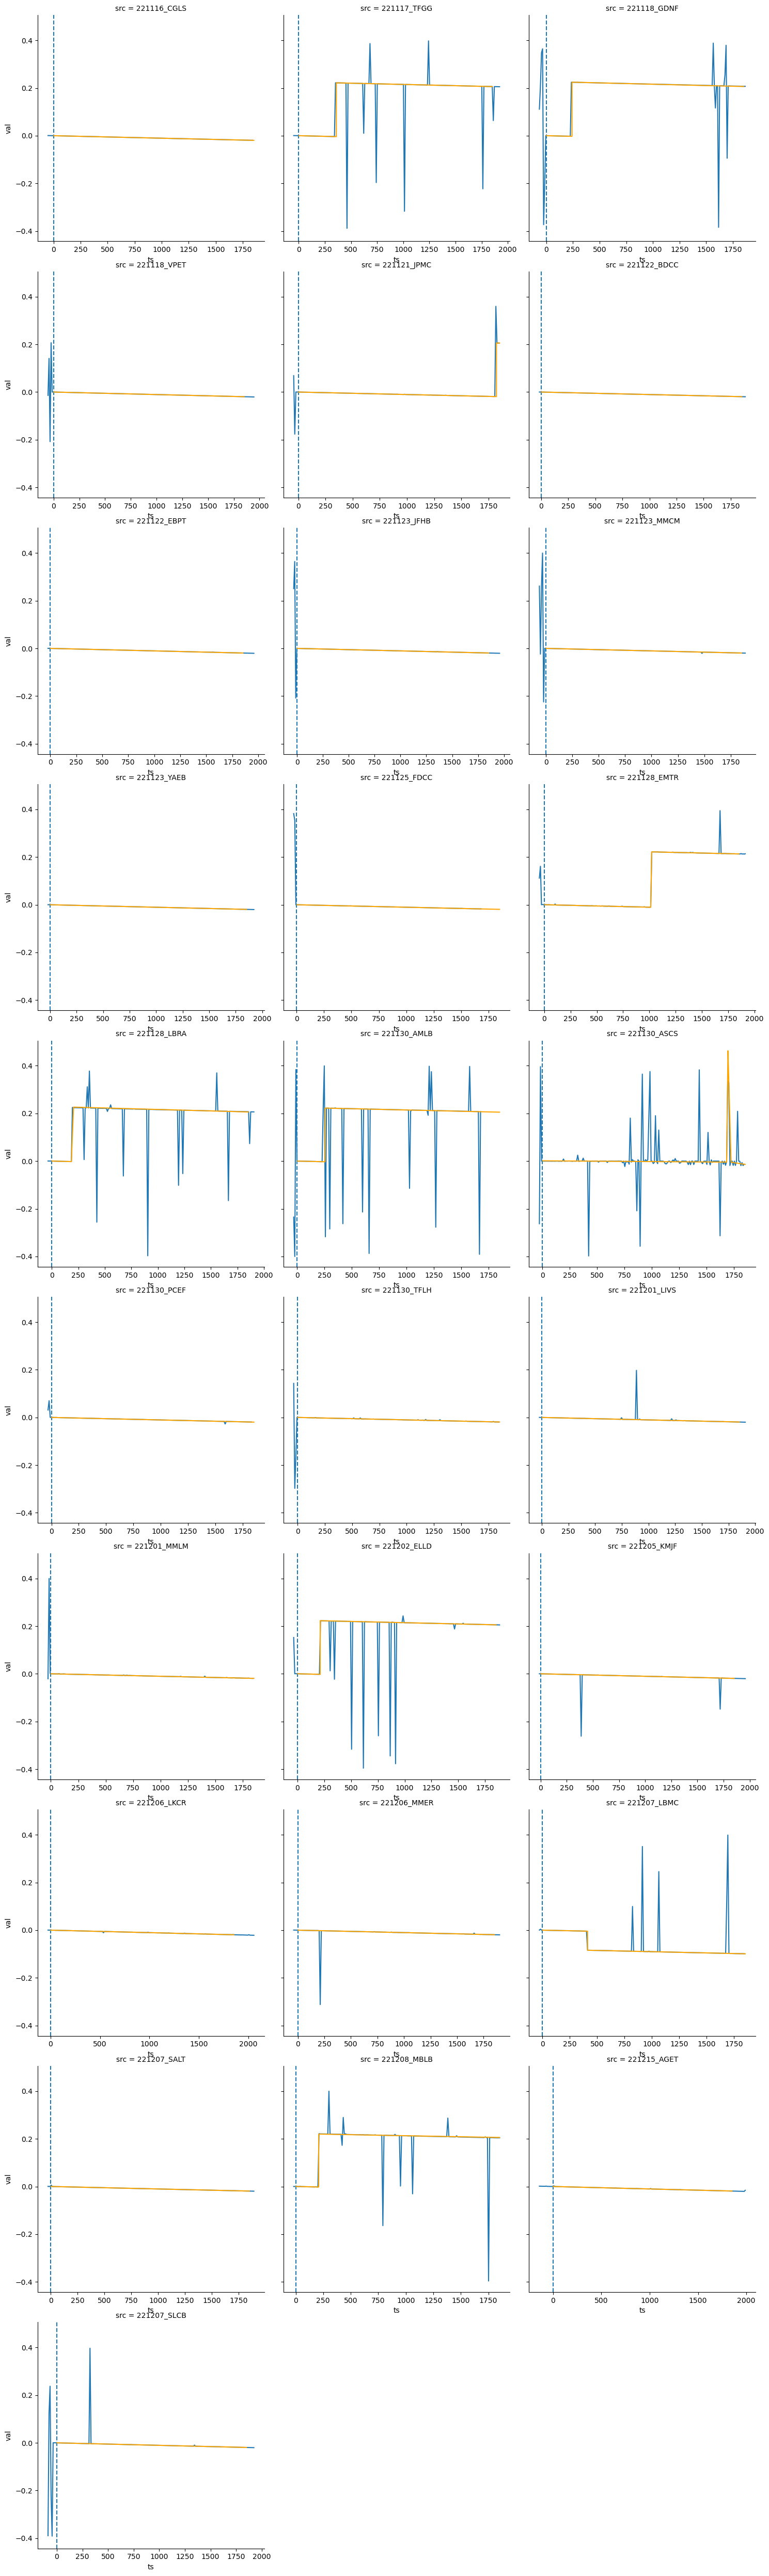

In [198]:
plot_drift(drift, best_models)

10it [07:57, 47.72s/it]


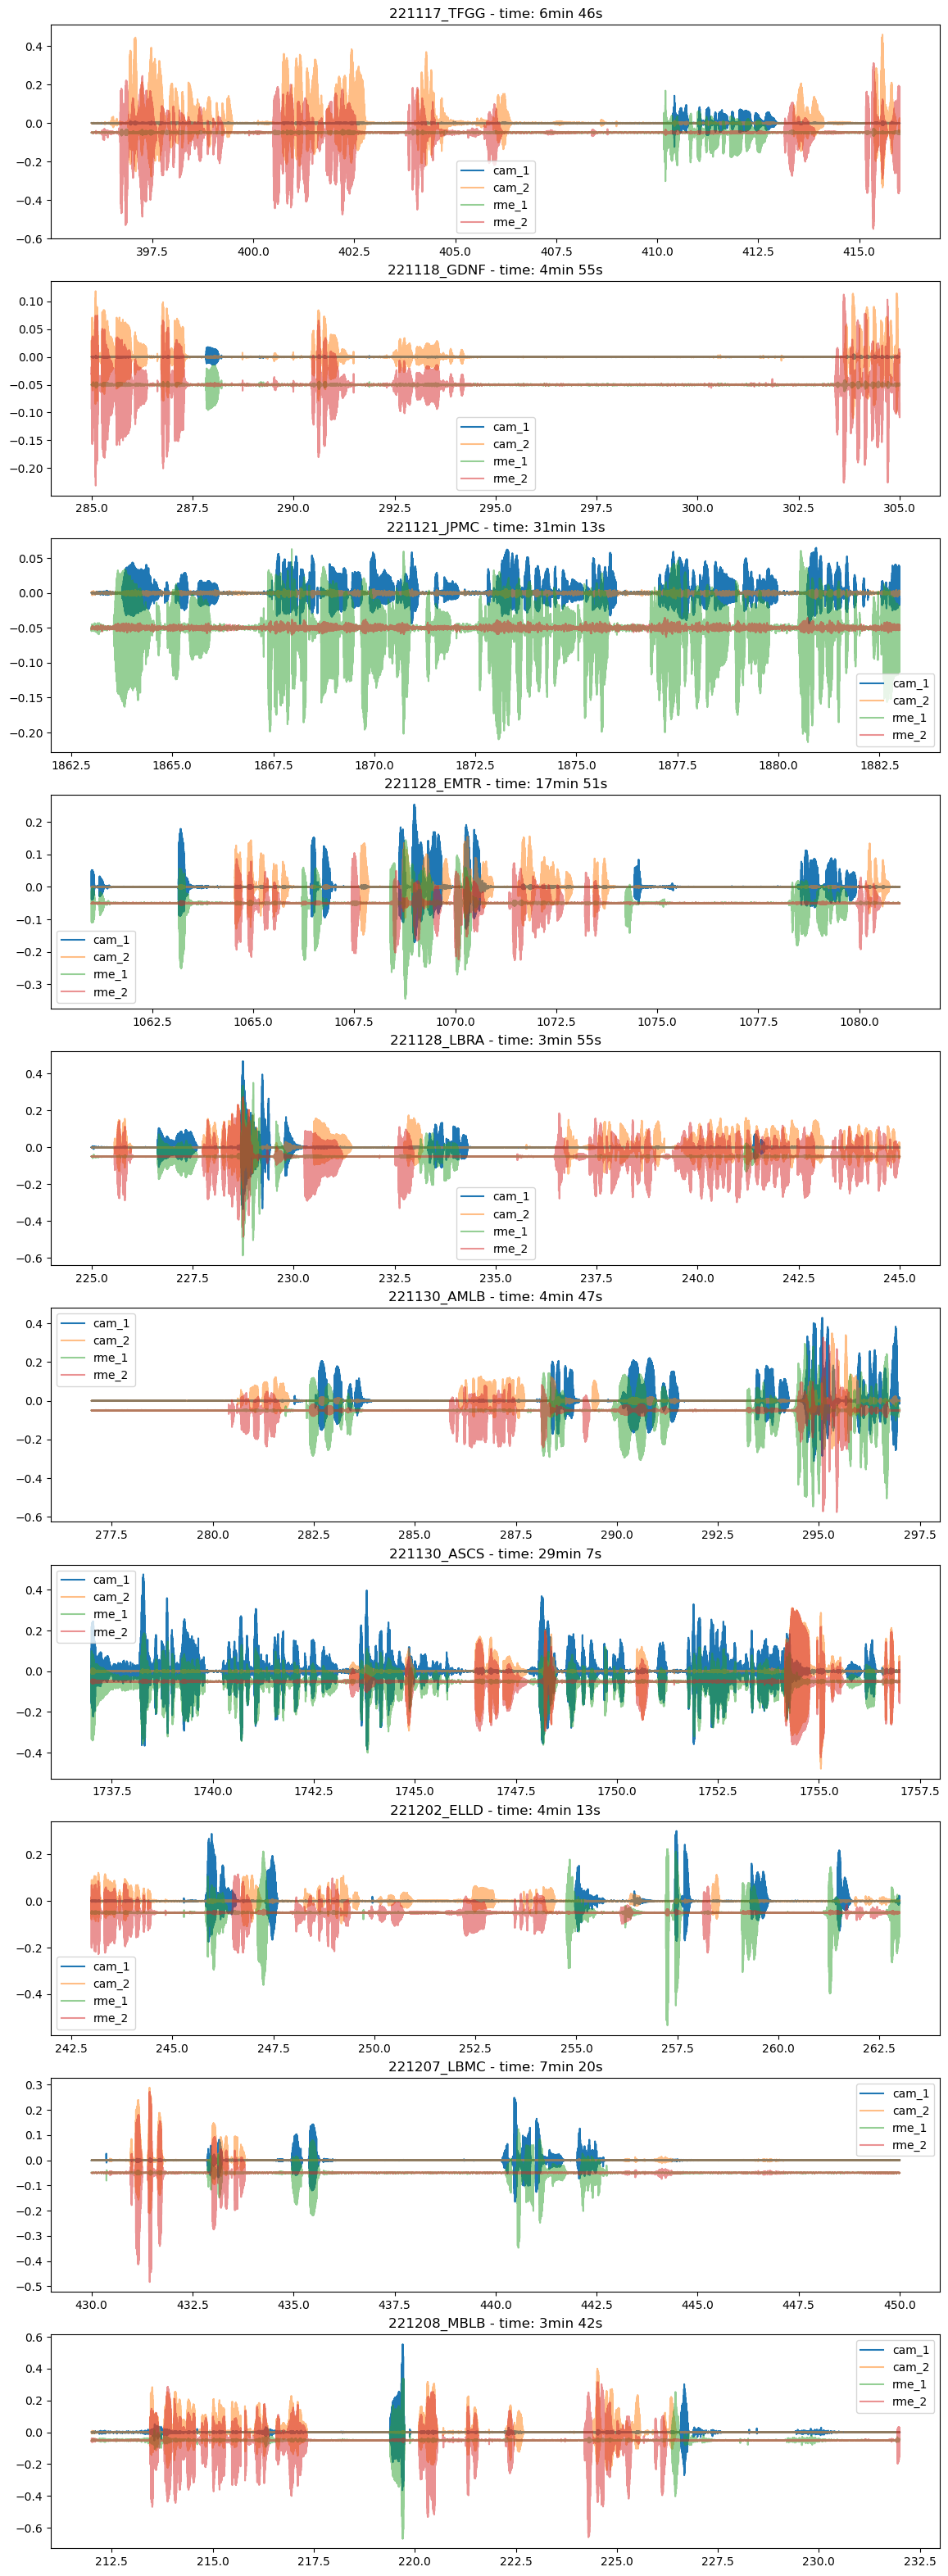

In [256]:
# takes time to reload everything
n = ko_files.shape[0]
fig, axes = plt.subplots(nrows=n, figsize=(14, 4*n))
for i, (file, row) in tqdm(enumerate(ko_files.iterrows())):
    [date, group] = file.split('_')
    ax = axes[i]
    # Load audios
    vaudio_align, vfs = librosa.load(os.path.join(dest_folder, f"bkt-{date}-{group}.wav"), sr=8000, mono=False) # Downsample 48kHz to 8kHz
    raudio_align, rfs = librosa.load(os.path.join(dest_folder, f"bkt-{date}-{group}_rme.wav"), sr=8000, mono=False)
    # Select time
    time = row['index']
    # Plot around time
    visual_check(vaudio_align, raudio_align, (int(time-10)*vfs,int(time+10)*vfs), fs=vfs, ax=ax)
    #ax.axvline(x=time, ymin=-0.1, ymax=0.1)
    ax.axhline(y=0, xmin=time, xmax=time+row['duration'], marker="s", color="black")
    ax.set_title(f"{file} - time: {int(time//60)}min {int(time%60)}s")